## TO DO

#### * Change all keys in YAML and inputs fro user to lower

In [1]:
import yaml
from mirage.src.mirage.processes import ProcessV1
from mirage.src.mirage.entities import EntityV1
from mirage.src.mirage.frameworks.epidemics import gpe
import pprint
from mirage.configs.simulations.epidemics.epidemic_constants import *
import numpy as np
import matplotlib.pyplot as plt
import gc

In [2]:
file_path = "D:/IIT MANDI/KBG Coordinator/MIRAZ/Epidemic_2/NEW_ENGINE/epidemic_engine/mirage/configs/simulations/epidemics/countries/india.yaml"
with open(file_path, 'r') as file:
    ind_config = yaml.load(file, Loader=yaml.FullLoader)
print(ind_config)

{'name': 'India', 'gdp': 2875140000, 'health_resource_stockpile': 50000.0, 'sanitation_equipment_stockpile': 50000.0, 'human_welfare_resource': 10000.0, 'happiness_index': 1.0, 'procedure_resistance': 0.6, 'cleanliness_index': 0.7, 'disease_research_center': 0, 'vaccine_research_center': 0, 'vaccines_stock': [{'name': 'ABC', 'quantity': 20, 'gdp_cost_per_step': 1000, 'effectiveness': 0.4}, {'name': 'ACB', 'quantity': 30, 'gdp_cost_per_step': 1000, 'effectiveness': 0.22}, {'name': 'BAC', 'quantity': 10, 'gdp_cost_per_step': 1000, 'effectiveness': 0.95}, {'name': 'BCA', 'quantity': 12, 'gdp_cost_per_step': 1000, 'effectiveness': -0.2}, {'name': 'CAB', 'quantity': 23, 'gdp_cost_per_step': 1000, 'effectiveness': 0.5}, {'name': 'CBA', 'quantity': 10, 'gdp_cost_per_step': 1000, 'effectiveness': 0.1}], 'loci': [{'name': 'Maharashtra', 'B': 0.001, 'C': 1e-06, 'E': 0.01, 'A': 0.01, 'Ds': 0.01, 'Di': 0.01, 'Dr': 0.01, 'lat': 19.7515, 'lon': 75.7139, 'susceptible': 112374333, 'infected': 100000, 

In [3]:
ind = gpe.Country(**ind_config)
gc.collect()

171

In [4]:
type(gpe.Country)

pydantic._internal._model_construction.ModelMetaclass

In [5]:
type(EntityV1)

pydantic._internal._model_construction.ModelMetaclass

In [6]:
cls = gpe.Country

In [7]:
ind

Country(name='India', gdp=2875140000.0, health_resource_stockpile=50000.0, sanitation_equipment_stockpile=50000.0, human_welfare_resource=10000.0, happiness_index=1.0, procedure_resistance=0.6, cleanliness_index=0.7, disease_research_center=0.0, vaccine_research_center=0.0, vaccines_stock=[{'name': 'ABC', 'quantity': 20, 'gdp_cost_per_step': 1000, 'effectiveness': 0.4}, {'name': 'ACB', 'quantity': 30, 'gdp_cost_per_step': 1000, 'effectiveness': 0.22}, {'name': 'BAC', 'quantity': 10, 'gdp_cost_per_step': 1000, 'effectiveness': 0.95}, {'name': 'BCA', 'quantity': 12, 'gdp_cost_per_step': 1000, 'effectiveness': -0.2}, {'name': 'CAB', 'quantity': 23, 'gdp_cost_per_step': 1000, 'effectiveness': 0.5}, {'name': 'CBA', 'quantity': 10, 'gdp_cost_per_step': 1000, 'effectiveness': 0.1}], loci=[Locus(name='Maharashtra', B=0.001, C=1e-06, E=0.01, A=0.01, Ds=0.01, Di=0.01, Dr=0.01, lat=19.7515, lon=75.7139, susceptible=112374333, infected=100000, recovered=200, dead=0, area=307713, quarantine_facilit

In [8]:
issubclass(gpe.Country, EntityV1)

True

In [9]:
val = lambda x: all(issubclass(dm, EntityV1) for dm in x)
val((gpe.Country, ))

True

### Birth Process ( A Parameter )

In [10]:
class BirthProcess(ProcessV1):
    RANK = 0
    DOMAIN = (gpe.Country,)

    def __init__(
        self,
        id: str,
        entities,
        status: str,
        alpha,
        beta,
        gamma,
        max_birth_rate,
        economic_prosperity_THRESH,
    ):
        super().__init__(id, entities, status)
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.max_birth_rate = max_birth_rate
        self.economic_prosperity_THRESH = economic_prosperity_THRESH
        self.status = status
        self.id = id

    def while_dormant(self, step: int):
        pass

    def while_alive(self, step: int):
        birth_rates = {}
        for country in self.entities:

            economic_prosperity = self.entities[country].human_welfare_resource

            for i, locus in enumerate(self.entities[country].loci):

                living_population_contribution = (
                    self.alpha * (locus.susceptible)
                    + self.beta * (locus.recovered)
                    + self.gamma * (locus.infected)
                ) / max_living_population

                if (economic_prosperity < self.economic_prosperity_THRESH) and (
                    economic_prosperity > base_birth_rate
                ):
                    birth_rate = (
                        (
                            self.alpha * (locus.susceptible)
                            + self.beta * (locus.recovered)
                            + self.gamma * (locus.infected)
                        )
                        * economic_prosperity
                        / max_living_population
                    )
                    if locus.A + birth_rate <= self.max_birth_rate:
                        locus.A += birth_rate
                    else:
                        locus.A = self.max_birth_rate

                elif economic_prosperity >= self.economic_prosperity_THRESH:
                    economic_prosperity_use = living_population_contribution * (
                        1 - (min_human_welfare_resource / economic_prosperity)
                    )
                    birth_rate = (
                        (2 / (1 + np.exp(-economic_prosperity_use))) - 1
                    ) * self.max_birth_rate

                    if locus.A + birth_rate <= self.max_birth_rate:
                        self.entities[country].loci[i].A += birth_rate
                    else:
                        locus.A = self.max_birth_rate
                elif economic_prosperity <= base_birth_rate:
                    birth_rate = base_birth_rate
                    if locus.A + birth_rate <= max_birth_rate:
                        locus.A += birth_rate
                    else:
                        locus.A = max_birth_rate
                birth_rates[
                    "BirthRate" + "_" + str(locus.name) + "_" + str(country)
                ] = locus.A

        return birth_rates

    def run(self, step: int):
        return self.while_alive(step)

In [11]:
birth_process = BirthProcess('BirthProcess', {"india": ind}, "ALIVE", 
                            alpha = 0.4, 
                            beta = 0.1, 
                            gamma = 0.6, 
                            max_birth_rate = 0.35, 
                            economic_prosperity_THRESH = 0.1 )

k = []
for i in range (10):
    k.append(birth_process.run(i))
    ind.sync()
k


[{'BirthRate_Maharashtra_india': 0.01,
  'BirthRate_Delhi_india': 0.01,
  'BirthRate_Uttar Pradesh_india': 0.01,
  'BirthRate_Rajasthan_india': 0.01,
  'BirthRate_Kerala_india': 0.01,
  'BirthRate_West Bengal_india': 0.01,
  'BirthRate_Gujarat_india': 0.01},
 {'BirthRate_Maharashtra_india': 0.010786881684536523,
  'BirthRate_Delhi_india': 0.010118481981887176,
  'BirthRate_Uttar Pradesh_india': 0.011398329560220202,
  'BirthRate_Rajasthan_india': 0.010480408217891592,
  'BirthRate_Kerala_india': 0.010234657849063047,
  'BirthRate_West Bengal_india': 0.010639342460722925,
  'BirthRate_Gujarat_india': 0.010423707005670505},
 {'BirthRate_Maharashtra_india': 0.011573763369073045,
  'BirthRate_Delhi_india': 0.010236963963774352,
  'BirthRate_Uttar Pradesh_india': 0.012796659120440404,
  'BirthRate_Rajasthan_india': 0.010960816435783184,
  'BirthRate_Kerala_india': 0.010469315698126093,
  'BirthRate_West Bengal_india': 0.011278684921445849,
  'BirthRate_Gujarat_india': 0.01084741401134101},


### **B PARMETER**

### MASK Implementation  (Reduce Vaue)

In [12]:
class MaskImplementationProcess(ProcessV1):
    RANK = 1
    DOMAIN = (gpe.Country,)

    def __init__(
        self,
        id: str,
        entities,
        status: str,
        state,
        health_resource_cost,
        sanitation_equipment_cost,
        main_scale,
    ):
        super().__init__(id, entities, status)
        self.health_resource_cost = health_resource_cost
        self.sanitation_equipment_cost = sanitation_equipment_cost
        self.state = state
        self.id = id
        self.main_scale = main_scale

    def while_dormant(self, step: int):
        pass

    def while_alive(self, step: int):
        for country in self.entities:
            health_resource = self.entities[country].health_resource_stockpile
            sanitation_equipment = self.entities[country].sanitation_equipment_stockpile

            for locus in self.entities[country].loci:
                if locus.name == self.state:
                    if (
                        health_resource >= self.health_resource_cost
                        and sanitation_equipment >= self.sanitation_equipment_cost
                    ):
                        if (
                            self.entities[country].health_resource_stockpile
                            - self.health_resource_cost
                            <= 0
                        ):
                            self.entities[country].health_resource_stockpile = 0
                        else:
                            self.entities[
                                country
                            ].health_resource_stockpile -= self.health_resource_cost
                        if (
                            self.entities[country].sanitation_equipment_stockpile
                            - self.sanitation_equipment_cost
                            <= 0
                        ):
                            self.entities[country].sanitation_equipment_stockpile = 0
                        else:
                            self.entities[
                                country
                            ].sanitation_equipment_stockpile -= (
                                self.sanitation_equipment_cost
                            )
                        if (
                            locus.B
                            - (
                                locus.B
                                * self.main_scale
                                * (locus.infected + locus.susceptible)
                                / (5e9)
                            )
                            >= 0
                        ):
                            locus.B -= (
                                locus.B
                                * self.main_scale
                                * (locus.infected + locus.susceptible)
                                / (5e9)
                            )
                            # print("in")
                        else:
                            locus.B -= 0
                    else:
                        # print(f"Insufficient resources for mask implementation {sanitation_equipment} sanitation equipment and {health_resource} health resources left in the stockpile.")

                        locus.B -= 0
                    print(locus.B)
                else:
                    pass
        return {
            "MaskImplementationProcess"
            + "_"
            + str(locus.name)
            + "_"
            + str(country): locus.B
            for locus in self.entities[country].loci
        }

    def run(self, step: int):
        return self.while_alive(step)

In [13]:
mask_implementaton_process = MaskImplementationProcess(
    "MaskImplementationProcess",
    {"india": ind},
    "ALIVE",
    state="Delhi",
    health_resource_cost=0.1,
    sanitation_equipment_cost=0.1,
    main_scale=0.1,
)

k = []
for i in range(10):
    k.append(mask_implementaton_process.run(i))
    ind.sync()

k

0.001
0.00099966224118
0.0009993245964410205
0.0009989870657445296
0.0009986496490520084
0.0009983123463249513
0.000997975157524865
0.00099763808261327
0.0009973011215516996
0.0009969642743016996


[{'MaskImplementationProcess_Maharashtra_india': 0.001,
  'MaskImplementationProcess_Delhi_india': 0.001,
  'MaskImplementationProcess_Uttar Pradesh_india': 0.001,
  'MaskImplementationProcess_Rajasthan_india': 0.001,
  'MaskImplementationProcess_Kerala_india': 0.001,
  'MaskImplementationProcess_West Bengal_india': 0.001,
  'MaskImplementationProcess_Gujarat_india': 0.001},
 {'MaskImplementationProcess_Maharashtra_india': 0.001,
  'MaskImplementationProcess_Delhi_india': 0.00099966224118,
  'MaskImplementationProcess_Uttar Pradesh_india': 0.001,
  'MaskImplementationProcess_Rajasthan_india': 0.001,
  'MaskImplementationProcess_Kerala_india': 0.001,
  'MaskImplementationProcess_West Bengal_india': 0.001,
  'MaskImplementationProcess_Gujarat_india': 0.001},
 {'MaskImplementationProcess_Maharashtra_india': 0.001,
  'MaskImplementationProcess_Delhi_india': 0.0009993245964410205,
  'MaskImplementationProcess_Uttar Pradesh_india': 0.001,
  'MaskImplementationProcess_Rajasthan_india': 0.001,

### AID KIT Implementation  (Reduce Vaue)

In [14]:
# Make AidKitImplementationProcess class similar to the above processes structure
class AidKitImplementationProcess(ProcessV1):
    RANK = 1
    DOMAIN = (gpe.Country,)

    def __init__(
        self,
        id: str,
        entities,
        status: str,
        state,
        healthcare_resource_cost,
        main_scale,
    ):
        super().__init__(id, entities, status)
        self.state = state
        self.healthcare_resource_cost = healthcare_resource_cost
        self.main_scale = main_scale
        self.status = status

    def while_dormant(self, step: int):
        pass

    def while_alive(self, step: int):
        for country in self.entities:
            sanitation_equipment = self.entities[country].health_resource_stockpile

            for locus in self.entities[country].loci:
                if locus.name == self.state:
                    if sanitation_equipment >= self.healthcare_resource_cost:
                        if (
                            self.entities[country].health_resource_stockpile
                            - self.healthcare_resource_cost
                            <= 0
                        ):
                            self.entities[country].sanitation_equipment_stockpile = 0
                        else:
                            self.entities[
                                country
                            ].health_resource_stockpile -= self.healthcare_resource_cost

                        if (
                            locus.B
                            - (
                                locus.B
                                * self.main_scale
                                * (locus.infected + locus.susceptible)
                                / (5e9)
                            )
                            >= 0
                        ):
                            locus.B -= (
                                locus.B
                                * self.main_scale
                                * (locus.infected + locus.susceptible)
                                / (5e9)
                            )
                        else:
                            locus.B -= 0
                    else:
                        locus.B -= 0

        return {
            "AidKitImplementationProcess"
            + "_"
            + str(locus.name)
            + "_"
            + str(country): locus.B
            for locus in self.entities[country].loci
        }

    def run(self, step: int):
        return self.while_alive(step)

In [15]:
Aid_kit_process = AidKitImplementationProcess(
    "AidKitImplementationProcess",
    {"india": ind},
    "ALIVE",
    state="Delhi",
    healthcare_resource_cost=0.1,
    main_scale=0.1,
)

k = []
for i in range(10):
    k.append(Aid_kit_process.run(i))
    ind.sync()

k

[{'AidKitImplementationProcess_Maharashtra_india': 0.001,
  'AidKitImplementationProcess_Delhi_india': 0.0009966275408248293,
  'AidKitImplementationProcess_Uttar Pradesh_india': 0.001,
  'AidKitImplementationProcess_Rajasthan_india': 0.001,
  'AidKitImplementationProcess_Kerala_india': 0.001,
  'AidKitImplementationProcess_West Bengal_india': 0.001,
  'AidKitImplementationProcess_Gujarat_india': 0.001},
 {'AidKitImplementationProcess_Maharashtra_india': 0.001,
  'AidKitImplementationProcess_Delhi_india': 0.0009962909210826608,
  'AidKitImplementationProcess_Uttar Pradesh_india': 0.001,
  'AidKitImplementationProcess_Rajasthan_india': 0.001,
  'AidKitImplementationProcess_Kerala_india': 0.001,
  'AidKitImplementationProcess_West Bengal_india': 0.001,
  'AidKitImplementationProcess_Gujarat_india': 0.001},
 {'AidKitImplementationProcess_Maharashtra_india': 0.001,
  'AidKitImplementationProcess_Delhi_india': 0.0009959544150367793,
  'AidKitImplementationProcess_Uttar Pradesh_india': 0.001

### General Sanitation Implementation  (Reduce Vaue)

In [16]:
# Make General_Sanitation_Implementation class similar to the above processes structure

class General_Sanitation_Implementation(ProcessV1):
    RANK = 1
    DOMAIN = (gpe.Country,)

    def __init__(
        self,
        id: str,
        entities,
        status: str,
        state,
        sanitation_equipment_cost,
        main_scale,
    ):
        super().__init__(id, entities, status)
        self.state = state
        self.sanitation_equipment_cost = sanitation_equipment_cost
        self.main_scale = main_scale
        self.status = status

    def while_dormant(self, step: int):
        pass

    def while_alive(self, step: int):
        for country in self.entities:
            sanitation_equipment = self.entities[country].sanitation_equipment_stockpile

            for locus in self.entities[country].loci:
                if locus.name == self.state:
                    if sanitation_equipment >= self.sanitation_equipment_cost:
                        if (
                            self.entities[country].sanitation_equipment_stockpile
                            - self.sanitation_equipment_cost
                            <= 0
                        ):
                            self.entities[country].sanitation_equipment_stockpile = 0
                        else:
                            self.entities[
                                country
                            ].sanitation_equipment_stockpile -= (
                                self.sanitation_equipment_cost
                            )

                        if (
                            locus.B
                            - (
                                locus.B
                                * self.main_scale
                                * (locus.infected + locus.susceptible)
                                / (5e9)
                            )
                            >= 0
                        ):
                            locus.B -= (
                                locus.B
                                * self.main_scale
                                * (locus.infected + locus.susceptible)
                                / (5e9)
                            )
                        else:
                            locus.B -= 0
                    else:
                        locus.B -= 0

        return {
            "General_Sanitation_Implementation"
            + "_"
            + str(locus.name)
            + "_"
            + str(country): locus.B
            for locus in self.entities[country].loci
        }

In [17]:
Sanitation_Implementation = General_Sanitation_Implementation(
    "General_Sanitation_Implementation",
    {"india": ind},
    "ALIVE",
    state="Rajasthan",
    sanitation_equipment_cost=0.1,
    main_scale=0.3,
)

k = []
for i in range(10):
    k.append(Sanitation_Implementation.run(i))
    ind.sync()

k

[{'ALIVE/General_Sanitation_Implementation_Maharashtra_india': 0.001,
  'ALIVE/General_Sanitation_Implementation_Delhi_india': 0.000993266455130547,
  'ALIVE/General_Sanitation_Implementation_Uttar Pradesh_india': 0.001,
  'ALIVE/General_Sanitation_Implementation_Rajasthan_india': 0.001,
  'ALIVE/General_Sanitation_Implementation_Kerala_india': 0.001,
  'ALIVE/General_Sanitation_Implementation_West Bengal_india': 0.001,
  'ALIVE/General_Sanitation_Implementation_Gujarat_india': 0.001},
 {'ALIVE/General_Sanitation_Implementation_Maharashtra_india': 0.001,
  'ALIVE/General_Sanitation_Implementation_Delhi_india': 0.000993266455130547,
  'ALIVE/General_Sanitation_Implementation_Uttar Pradesh_india': 0.001,
  'ALIVE/General_Sanitation_Implementation_Rajasthan_india': 0.00099588109378,
  'ALIVE/General_Sanitation_Implementation_Kerala_india': 0.001,
  'ALIVE/General_Sanitation_Implementation_West Bengal_india': 0.001,
  'ALIVE/General_Sanitation_Implementation_Gujarat_india': 0.001},
 {'ALIV

### Environmental Cleaning Implementation  (Reduce Vaue)

In [18]:
# Make EnvironmentalCleaningProcess class similar to the above processes structure
class EnvironmentalCleaningProcess(ProcessV1):
    RANK = 1
    DOMAIN = (gpe.Country,)

    def __init__(
        self,
        id: str,
        entities,
        status: str,
        state,
        environmental_cleaning_cost,
        main_scale,
    ):
        super().__init__(id, entities, status)
        self.state = state
        self.environmental_cleaning_cost = environmental_cleaning_cost
        self.main_scale = main_scale
        self.status = status

    def while_dormant(self, step: int):
        pass

    def while_alive(self, step: int):
        for country in self.entities:
            environmental_cleaning = self.entities[
                country
            ].sanitation_equipment_stockpile

            for locus in self.entities[country].loci:
                if locus.name == self.state:
                    if environmental_cleaning >= self.environmental_cleaning_cost:
                        if (
                            self.entities[country].sanitation_equipment_stockpile
                            - self.environmental_cleaning_cost
                            <= 0
                        ):
                            self.entities[country].environmental_cleaning_stockpile = 0
                        else:
                            self.entities[
                                country
                            ].sanitation_equipment_stockpile -= (
                                self.environmental_cleaning_cost
                            )
                        if (
                            locus.B
                            - (
                                locus.B
                                * self.main_scale
                                * (locus.infected + locus.susceptible)
                                / (5e9)
                            )
                            >= 0
                        ):
                            locus.B -= (
                                locus.B
                                * self.main_scale
                                * (locus.infected + locus.susceptible)
                                / (5e9)
                            )
                        else:
                            locus.B -= 0
                    else:
                        locus.B -= 0
        return {
            "EnvironmentalCleaningProcess"
            + "_"
            + str(locus.name)
            + "_"
            + str(country): locus.B
            for locus in self.entities[country].loci
        }

    def run(self, step: int):
        return self.while_alive(step)

In [19]:
environmental_cleaning_process = EnvironmentalCleaningProcess(
    "EnvironmentalCleaningProcess",
    {"india": ind},
    "ALIVE",
    state="Kerala",
    environmental_cleaning_cost=0.1,
    main_scale=0.3,
)

k = []
for i in range(10):
    k.append(environmental_cleaning_process.run(i))
    ind.sync()

k

[{'EnvironmentalCleaningProcess_Maharashtra_india': 0.001,
  'EnvironmentalCleaningProcess_Delhi_india': 0.000993266455130547,
  'EnvironmentalCleaningProcess_Uttar Pradesh_india': 0.001,
  'EnvironmentalCleaningProcess_Rajasthan_india': 0.0009595660549643279,
  'EnvironmentalCleaningProcess_Kerala_india': 0.001,
  'EnvironmentalCleaningProcess_West Bengal_india': 0.001,
  'EnvironmentalCleaningProcess_Gujarat_india': 0.001},
 {'EnvironmentalCleaningProcess_Maharashtra_india': 0.001,
  'EnvironmentalCleaningProcess_Delhi_india': 0.000993266455130547,
  'EnvironmentalCleaningProcess_Uttar Pradesh_india': 0.001,
  'EnvironmentalCleaningProcess_Rajasthan_india': 0.0009595660549643279,
  'EnvironmentalCleaningProcess_Kerala_india': 0.00099798963634,
  'EnvironmentalCleaningProcess_West Bengal_india': 0.001,
  'EnvironmentalCleaningProcess_Gujarat_india': 0.001},
 {'EnvironmentalCleaningProcess_Maharashtra_india': 0.001,
  'EnvironmentalCleaningProcess_Delhi_india': 0.000993266455130547,
  

### Changing Effect size of Economic Zones (Indirect impact on B Parameter) (Reduces B and GDP trickle from Zone)

In [22]:
ind = gpe.Country(**ind_config)

In [23]:
class EconomicZoneEffectChangeProcess(ProcessV1):
    RANK = 1
    DOMAIN = (gpe.Country,)

    def __init__(
        self,
        id: str,
        entities,
        status: str,
        change_country,
        economic_zone_names,
        effect,
    ):

        # Give Country and economic zone name as list with same index corresponding to each others country (with same name as Initialized Entity) and economic zone name

        #super().__init__(id, entities, status)
        self.change_country = change_country
        self.economic_zone_names = economic_zone_names
        self.effect = effect
        self.status = status

    def while_dormant(self, step: int):
        pass

    def while_alive(self, step: int):
        if len(self.change_country) != len(self.economic_zone_names):
            raise ValueError(
                "Length of change country, economic_zone_name and effect should be same"
            )

        elif len(self.change_country) == 0:
            print("here")
            # go through all the countries and increase the B value of locus based on available economic zone and its b_value_increase
            for country in self.entities.keys():
                for locus in self.entities[country].loci:
                    total_b_increase = 0
                    for economicZone in locus.economic_zones:
                        total_b_increase += economicZone["b_val_increase"]
                    locus.B += total_b_increase

        elif len(self.change_country) > 0 and len(self.change_country) == len(
            self.economic_zone_names
        ):
            #print("in")
            for i, country in enumerate(self.change_country):
                b_vals = [0.0005, 0.0003, 0.0001]
                for locus in self.entities[country].loci:
                    for economicZone in locus.economic_zones:
                        #print(economicZone["name"])
                        if economicZone["name"] == self.economic_zone_names[i]:
                            #print("Yes")
                            economicZone["effect"] = self.effect[i]
                            #economicZone["b_val_increase"] = float(b_vals[economicZone["zone_tier"]] * economicZone["effect"])
                        break
                    break
            #print("here")
                            

            # got through all cities and increase the B value of locus based on available economic zone and its b_value_increase
            for country in self.entities.keys():
                for locus in self.entities[country].loci:
                    total_b_increase = 0
                    if locus.economic_zones != None:
                        for economicZone in locus.economic_zones:
                            #print(economicZone["name"], economicZone["b_val_increase"])
                            total_b_increase += truncated_sig
                        #print(locus.name, total_b_increase, "name", "Increase")
                        locus.B += total_b_increase
        return {
            "EconomicZoneEffectChangeProcess"
            + "_"
            + str(locus.name)
            + "_"
            + str(country): locus.B
            for locus in self.entities[country].loci
        }

    def run(self, step):
        if self.status == "ALIVE":
            return self.while_alive(step)

In [25]:
economic_zone_effect_change_process = EconomicZoneEffectChangeProcess(
    "EconomicZoneEffectChangeProcess",
    {"india": ind},  # give all counties to this entity here
    "ALIVE",
    change_country=["india"],
    economic_zone_names=["Ahmedabad SEZ"],
    effect=0.5,
)

k = []
for i in range(10):
    k.append(economic_zone_effect_change_process.run(i))
    ind.sync()

k

KeyError: 'b_val_increase'

### Changing tourist areas effect and then updates B value or If not provided with area to affect will do its regular increase to all regions

In [ ]:
class TouristZoneEffectChangeProcess(ProcessV1):
    RANK = 1
    DOMAIN = (gpe.Country,)

    def __init__(
        self,
        id: str,
        entities,
        status: str,
        change_country,
        tourist_zone_names,
        effect,
    ):

        # Give Country and economic zone name as list with same index corresponding to each others country (with same name as Initialized Entity) and economic zone name

        super().__init__(id, entities, status)
        self.change_country = change_country
        self.tourist_zone_names = tourist_zone_names
        self.effect = effect
        self.status = status

    def while_dormant(self, step: int):
        pass

    def while_alive(self, step: int):
        if len(self.change_country) != len(self.tourist_zone_names):
            raise ValueError(
                "Length of change country, economic_zone_name and effect should be same"
            )

        elif len(self.change_country) == 0:
            print("here")
            # go through all the countries and increase the B value of locus based on available economic zone and its b_value_increase
            for country in self.entities.keys():
                for locus in self.entities[country].loci:
                    total_b_increase = 0
                    for touristZone in locus.tourist_zones:
                        total_b_increase += touristZone["b_val_increase"]
                    locus.B += total_b_increase

        elif len(self.change_country) > 0 and len(self.change_country) == len(
            self.tourist_zone_names
        ):
            #print("in")
            for i, country in enumerate(self.change_country):
                b_vals = [0.0005, 0.0003, 0.0001]
                for locus in self.entities[country].loci:
                    for touristZone in locus.tourist_zones:
                        #print(touristZone["name"])
                        if touristZone["name"] == self.tourist_zone_names[i]:
                            #print("Yes")
                            touristZone["effect"] = self.effect[i]
                            touristZone["b_val_increase"] = float(b_vals[touristZone["zone_tier"]] * touristZone["effect"])
                        break
                    break
            #print("here")
                            

            # got through all cities and increase the B value of locus based on available economic zone and its b_value_increase
            for country in self.entities.keys():
                for locus in self.entities[country].loci:
                    total_b_increase = 0
                    if locus.tourist_zones != None:
                        for touristZone in locus.tourist_zones:
                            #print(touristZone["name"], touristZone["b_val_increase"])
                            total_b_increase += touristZone["b_val_increase"]
                        #print(locus.name, total_b_increase, "name", "Increase")
                        locus.B += total_b_increase
                        #print(locus.B, "increaseB")
                    

        return {
            "TouristZoneEffectChangeProcess"
            + "_"
            + str(locus.name)
            + "_"
            + str(country): locus.B
            for locus in self.entities[country].loci
        }

    def run(self, step: int):
        if self.status == "ALIVE":
            return self.while_alive(step)

In [ ]:
tourist_zone_effect_change_process = TouristZoneEffectChangeProcess(
    "TouristZoneEffectChangeProcess",
    {"india": ind},  # give all counties to this entity here
    "ALIVE",
    change_country=["india"],
    tourist_zone_names=["Sabarmati Ashram"],
    effect=[0.0],
)

k = []
for i in range(10):
    k.append(tourist_zone_effect_change_process.run(i))
    ind.sync()

k

[{'TouristZoneEffectChangeProcess_Maharashtra_india': 0.010700000000000006,
  'TouristZoneEffectChangeProcess_Delhi_india': 0.010632664551305477,
  'TouristZoneEffectChangeProcess_Uttar Pradesh_india': 0.010499999999999997,
  'TouristZoneEffectChangeProcess_Rajasthan_india': 0.010095660549643273,
  'TouristZoneEffectChangeProcess_Kerala_india': 0.010300772621128346,
  'TouristZoneEffectChangeProcess_West Bengal_india': 0.010599999999999993,
  'TouristZoneEffectChangeProcess_Gujarat_india': 0.010599999999999993},
 {'TouristZoneEffectChangeProcess_Maharashtra_india': 0.010770000000000007,
  'TouristZoneEffectChangeProcess_Delhi_india': 0.010702664551305478,
  'TouristZoneEffectChangeProcess_Uttar Pradesh_india': 0.010559999999999996,
  'TouristZoneEffectChangeProcess_Rajasthan_india': 0.010165660549643274,
  'TouristZoneEffectChangeProcess_Kerala_india': 0.010370772621128347,
  'TouristZoneEffectChangeProcess_West Bengal_india': 0.010649999999999993,
  'TouristZoneEffectChangeProcess_Guj

In [ ]:
class PortEffectChangeProcess(ProcessV1):
    RANK = 1
    DOMAIN = (gpe.Country,)

    def __init__(
        self,
        id: str,
        entities,
        status: str,
        change_country,
        port_names,
        effect,
    ):

        # Give Country and economic zone name as list with same index corresponding to each others country (with same name as Initialized Entity) and economic zone name

        super().__init__(id, entities, status)
        self.change_country = change_country
        self.port_names = port_names
        self.effect = effect
        self.status = status

    def while_dormant(self, step: int):
        pass

    def while_alive(self, step: int):
        if len(self.change_country) != len(self.port_names):
            raise ValueError(
                "Length of change country, economic_zone_name and effect should be same"
            )

        elif len(self.change_country) == 0:
            print("here")
            # go through all the countries and increase the B value of locus based on available economic zone and its b_value_increase
            for country in self.entities.keys():
                for locus in self.entities[country].loci:
                    total_b_increase = 0
                    for port in locus.ports:
                        total_b_increase += port["b_val_increase"]
                    locus.B += total_b_increase

        elif len(self.change_country) > 0 and len(self.change_country) == len(
            self.port_names
        ):
            #print("in")
            for i, country in enumerate(self.change_country):
                b_vals = [0.005, 0.003, 0.001]
                for locus in self.entities[country].loci:
                    for port in locus.ports:
                        #print(port["name"])
                        if port["name"] == self.port_names[i]:
                            #print("Yes")
                            port["effect"] = self.effect[i]
                            port["b_val_increase"] = float(b_vals[port["zone_tier"]] * port["effect"])
                        break
                    break
            #print("here")
                            

            # got through all cities and increase the B value of locus based on available economic zone and its b_value_increase
            for country in self.entities.keys():
                for locus in self.entities[country].loci:
                    total_b_increase = 0
                    if locus.ports != None:
                        for port in locus.ports:
                            #print(port["name"], port["b_val_increase"])
                            total_b_increase += port["b_val_increase"]
                        #print(locus.name, total_b_increase, "name", "Increase")
                        locus.B += total_b_increase
                        #print(locus.B, "increaseB")
                    

        return {
            "PortEffectChangeProcess"
            + "_"
            + str(locus.name)
            + "_"
            + str(country): locus.B
            for locus in self.entities[country].loci
        }

    def run(self, step: int):
        if self.status == "ALIVE":
            return self.while_alive(step)

In [ ]:
port_effect_change_process = PortEffectChangeProcess(
    "PortEffectChangeProcess",
    {"india": ind},  # give all counties to this entity here
    "ALIVE",
    change_country=["india"],
    port_names=["Kandla Port"],
    effect=[0.0],
)

k = []
for i in range(10):
    k.append(port_effect_change_process.run(i))
    ind.sync()

k

[{'PortEffectChangeProcess_Maharashtra_india': 0.011400000000000013,
  'PortEffectChangeProcess_Delhi_india': 0.011332664551305483,
  'PortEffectChangeProcess_Uttar Pradesh_india': 0.01109999999999999,
  'PortEffectChangeProcess_Rajasthan_india': 0.01079566054964328,
  'PortEffectChangeProcess_Kerala_india': 0.011000772621128353,
  'PortEffectChangeProcess_West Bengal_india': 0.01109999999999999,
  'PortEffectChangeProcess_Gujarat_india': 0.01109999999999999},
 {'PortEffectChangeProcess_Maharashtra_india': 0.012300000000000012,
  'PortEffectChangeProcess_Delhi_india': 0.011332664551305483,
  'PortEffectChangeProcess_Uttar Pradesh_india': 0.01109999999999999,
  'PortEffectChangeProcess_Rajasthan_india': 0.01079566054964328,
  'PortEffectChangeProcess_Kerala_india': 0.011800772621128353,
  'PortEffectChangeProcess_West Bengal_india': 0.01159999999999999,
  'PortEffectChangeProcess_Gujarat_india': 0.01189999999999999},
 {'PortEffectChangeProcess_Maharashtra_india': 0.013200000000000012,
 

In [ ]:
# Make a process to increase the number of disease research centers in each locus mentioned in state list if the country has enough GDP and recovered people in that locus. Also increase the recovery rate "C" based on the number of disease research centers. Add a trickle of Healthcare resource stockpile, Sanitation Equipment stockpile and Human Welfare resource. Also use some gdp of the counrry for every building of disease research center
class QuarantineFacilitiesQProcess(ProcessV1):
    RANK = 1
    DOMAIN = (gpe.Country,)

    def __init__(
        self,
        id: str,
        entities,
        status: str,
        country,
        state,
        num_centers,
        gdp_cost_per_center=500,
        health_resource_cost=20,
        sanitation_equipment_cost=20,
    ):
        super().__init__(id, entities, status)
        self.gdp_cost_per_center = gdp_cost_per_center
        self.country = country
        self.num_centers = num_centers
        self.state = state
        self.health_resource_cost = health_resource_cost
        self.sanitation_equipment_cost = sanitation_equipment_cost

    def while_dormant(self, step: int):
        pass

    def while_alive(self, step: int):
        for i, country in enumerate(self.country):
            for locus in self.entities[country].loci:
                if locus.name == self.state[i]:
                    print("Added Quarantine Center in", locus.name)
                    if (
                        self.entities[country].gdp >= self.gdp_cost_per_center * self.num_centers[i] and 
                        self.entities[country].health_resource_stockpile >= self.health_resource_cost * self.num_centers[i]and
                        self.entities[country].sanitation_equipment_stockpile >= self.sanitation_equipment_cost *self.num_centers[i] 
                    ):
                        # Deduct the costs from the country's GDP
                        self.entities[country].gdp -= self.gdp_cost_per_center * self.num_centers[i]
                        self.entities[country].health_resource_stockpile -= self.health_resource_cost * self.num_centers[i]
                        self.entities[country].sanitation_equipment_stockpile -= self.sanitation_equipment_cost * self.num_centers[i]

                        # Increase the number of disease research centers in the locus
                        locus.quarantine_facilities += self.num_centers[i]
                    else:
                        # print("pass1")
                        pass
                if (
                    locus.quarantine_facilities > 0
                ):
                    print(locus.name, "in first if")
                    print(locus.C)
                    print(locus.quarantine_facilities, "before")
                    # Reduce the recovery rate "C" based on the number of disease research centers
                    if locus.quarantine_facilities * 0.0001 <= 0.001:
                        locus.C += locus.quarantine_facilities * 0.0001
                    else:
                        locus.C += 0.001
                    print(locus.C, "after")
                    print(locus.quarantine_facilities, "after")
                    print("***********")

                    # # Add a trickle of Healthcare resource stockpile, Sanitation Equipment stockpile and Human Welfare resource
                    # self.entities[country].health_resource_stockpile += 0.5
                    # self.entities[country].sanitation_equipment_stockpile += 0.5
                    # self.entities[country].human_welfare_resource += 0.2

                # else:
                #     print("inElse")
                #     print(locus.name)
                #     print(locus.recovered, self.min_recovered_people)
                #     print(self.entities[country].disease_research_center)
        # retunr the recovery rate "C" of each locus
        return {
            "QuarantineFacilitiesQProcess"
            + "_"
            + str(locus.name)
            + "_"
            + str(country): locus.C
            for locus in self.entities[country].loci
        }

    def run(self, step: int):
        if self.status == "ALIVE":
            return self.while_alive(step)

In [ ]:
QuarantineFacilities_building_process = QuarantineFacilitiesQProcess(
    "QuarantineFacilitiesQProcess",
    {"india": ind},
    "ALIVE",
    country=["india", "india"],
    state=["West Bengal", "Rajasthan"],
    num_centers=[1, 5],
)

k = []
for i in range(10):
    k.append(QuarantineFacilities_building_process.run(i))
    ind.sync()

k

Maharashtra in first if
0.01
2 before
0.01 after
2 after
***********
Delhi in first if
0.01
2 before
0.01 after
2 after
***********
Uttar Pradesh in first if
0.01
2 before
0.01 after
2 after
***********
Rajasthan in first if
0.01
2 before
0.01 after
2 after
***********
Kerala in first if
0.01
2 before
0.01 after
2 after
***********
Added Quarantine Center in West Bengal
West Bengal in first if
0.01
2 before
0.01 after
2 after
***********
Gujarat in first if
0.01
2 before
0.01 after
2 after
***********
Maharashtra in first if
0.01
2 before
0.01 after
2 after
***********
Delhi in first if
0.01
2 before
0.01 after
2 after
***********
Uttar Pradesh in first if
0.01
2 before
0.01 after
2 after
***********
Added Quarantine Center in Rajasthan
Rajasthan in first if
0.01
2 before
0.01 after
2 after
***********
Kerala in first if
0.01
2 before
0.01 after
2 after
***********
West Bengal in first if
0.01
2 before
0.01 after
2 after
***********
Gujarat in first if
0.01
2 before
0.01 after
2 after


[{'QuarantineFacilitiesQProcess_Maharashtra_india': 0.01,
  'QuarantineFacilitiesQProcess_Delhi_india': 0.01,
  'QuarantineFacilitiesQProcess_Uttar Pradesh_india': 0.01,
  'QuarantineFacilitiesQProcess_Rajasthan_india': 0.01,
  'QuarantineFacilitiesQProcess_Kerala_india': 0.01,
  'QuarantineFacilitiesQProcess_West Bengal_india': 0.01,
  'QuarantineFacilitiesQProcess_Gujarat_india': 0.01},
 {'QuarantineFacilitiesQProcess_Maharashtra_india': 0.0102,
  'QuarantineFacilitiesQProcess_Delhi_india': 0.0102,
  'QuarantineFacilitiesQProcess_Uttar Pradesh_india': 0.0102,
  'QuarantineFacilitiesQProcess_Rajasthan_india': 0.0102,
  'QuarantineFacilitiesQProcess_Kerala_india': 0.0102,
  'QuarantineFacilitiesQProcess_West Bengal_india': 0.0102,
  'QuarantineFacilitiesQProcess_Gujarat_india': 0.0102},
 {'QuarantineFacilitiesQProcess_Maharashtra_india': 0.010400000000000001,
  'QuarantineFacilitiesQProcess_Delhi_india': 0.010400000000000001,
  'QuarantineFacilitiesQProcess_Uttar Pradesh_india': 0.0104

### ONLY INCREASE in B from Machine processs

Run this after all implementation processes

In [ ]:
# Make a process increase B due to Susceptable population density, Baseline Infection rate, Cleanliness index in each of loci of all countries in entities
class IncreaseBProcess(ProcessV1):
    RANK = 1
    DOMAIN = (gpe.Country,)

    def __init__(self, id: str, entities, status: str, infected_country: str):
        super().__init__(id, entities, status)
        self.infected_country = infected_country

    def while_dormant(self, step: int):
        pass

    def calculate_increase_factor(
        self, susceptible_population_density, baseline_infection_rate, cleanliness_index
    ):
        increase_factor = (
            susceptible_population_density
            * baseline_infection_rate
            * (1 - cleanliness_index)
        )
        return increase_factor

    def while_alive(self, step: int):
        for country in self.entities:
            if country != self.infected_country:
                for locus in country.loci:
                    susceptible_population_density = locus.susceptible / (
                        max_living_population * locus.area
                    )
                    increase_factor = self.calculate_increase_factor(
                        susceptible_population_density,
                        baseline_infection_rate,
                        self.cleanliness_index,
                    )
                    if locus.B + increase_factor <= 0.0005:
                        locus.B += increase_factor
                    else:
                        locus.B = 0.0005

                    # Move locus.B percent of people from susceptible to infected
                    if locus.susceptible > 0:
                        locus.infected += locus.susceptible * locus.B
                        locus.susceptible -= locus.susceptible * locus.B
                    else:
                        locus.susceptible = 0

            else:
                for locus in country.loci:
                    susceptible_population_density = locus.susceptible / (
                        max_living_population * locus.area
                    )
                    increase_factor = self.calculate_increase_factor(
                        susceptible_population_density,
                        epidemic_increased_infection_rate,
                        self.cleanliness_index,
                    )
                    if locus.B + increase_factor <= 0.0009:
                        locus.B += increase_factor
                    else:
                        locus.B = 0.0009

                    if locus.susceptible > 0:
                        locus.infected += locus.susceptible * locus.B
                        locus.susceptible -= locus.susceptible * locus.B
                    else:
                        locus.susceptible = 0

        # return number of susceptable, infected and recovered people in each locus
        return {
            "IncreaseBProcess"
            + "_"
            + str(locus.name)
            + "_"
            + str(country): [
                locus.susceptible,
                locus.infected,
                locus.recovered,
                locus.dead,
            ]
            for locus in self.entities[country].loci
        }

    def run(self):
        if self.status == "ALIVE":
            return self.while_active()

### **C PARAMETER**

#### General Hospital increase value (user input) 

In [ ]:
ind = gpe.Country(**ind_config)

In [ ]:
# Make increase number of genreal hospitals in each locus mentioned in state list if the country has enough GDP and recovered people in that locus. Also increase the recovery rate "C" based on the number of hospitals in that locus and population density (if more then increase in C is lower)

class GeneralHospitalBuildingProcess(ProcessV1):
    RANK = 1
    DOMAIN = (gpe.Country,)

    def __init__(
        self,
        id: str,
        entities,
        status: str,
        country,
        state,
        num_hospitals,
        gdp_cost_per_hospital=500,
        min_recovered_people=50,
    ):
        super().__init__(id, entities, status)
        self.gdp_cost_per_hospital = gdp_cost_per_hospital
        self.min_recovered_people = min_recovered_people
        self.num_hospitals = num_hospitals
        self.country = country
        self.num_hospitals = num_hospitals
        self.state = state

    def while_dormant(self, step: int):
        pass

    def while_alive(self, step: int):
        for i, country in enumerate(self.country):
            for locus in self.entities[country].loci:
                if locus.name == self.state[i]:
                    if (
                        self.entities[country].gdp >= self.gdp_cost_per_hospital
                        and locus.recovered >= self.min_recovered_people
                    ):
                        # Deduct the costs from the country's GDP
                        self.entities[country].gdp -= self.gdp_cost_per_hospital * self.num_hospitals[i]

                        # Increase the number of hospitals in the locus
                        locus.general_hospitals += self.num_hospitals[i]
                    else:
                        print("pass1")
                        pass
                if locus.recovered >= self.min_recovered_people and locus.general_hospitals > 0:
                    # Reduce the recovery rate "C" based on the number of hospitals
                    if  locus.general_hospitals * 0.0005 <= 0.001:
                        locus.C += locus.general_hospitals * 0.005
                    else:
                        locus.C += 0.001


        return {
            "GeneralHospitalBuildingProcess"
            + "_"
            + str(locus.name)
            + "_"
            + str(country): locus.C
            for locus in self.entities[country].loci
        }

    def run(self, step: int):
        if self.status == "ALIVE":
            return self.while_alive(step)

In [ ]:
general_hospital_building_process = GeneralHospitalBuildingProcess(
    "GeneralHospitalBuildingProcess",
    {"india": ind},
    "ALIVE",
    country=["india", "india"],
    state=["Delhi", "Gujarat"],
    num_hospitals=[1, 5],
)

k = []
for i in range(100):
    k.append(general_hospital_building_process.run(i))
    ind.sync()

k

[{'GeneralHospitalBuildingProcess_Maharashtra_india': 0.01,
  'GeneralHospitalBuildingProcess_Delhi_india': 0.01,
  'GeneralHospitalBuildingProcess_Uttar Pradesh_india': 0.01,
  'GeneralHospitalBuildingProcess_Rajasthan_india': 0.01,
  'GeneralHospitalBuildingProcess_Kerala_india': 0.01,
  'GeneralHospitalBuildingProcess_West Bengal_india': 0.01,
  'GeneralHospitalBuildingProcess_Gujarat_india': 0.01},
 {'GeneralHospitalBuildingProcess_Maharashtra_india': 0.011,
  'GeneralHospitalBuildingProcess_Delhi_india': 0.011,
  'GeneralHospitalBuildingProcess_Uttar Pradesh_india': 0.011,
  'GeneralHospitalBuildingProcess_Rajasthan_india': 0.011,
  'GeneralHospitalBuildingProcess_Kerala_india': 0.011,
  'GeneralHospitalBuildingProcess_West Bengal_india': 0.011,
  'GeneralHospitalBuildingProcess_Gujarat_india': 0.015},
 {'GeneralHospitalBuildingProcess_Maharashtra_india': 0.012,
  'GeneralHospitalBuildingProcess_Delhi_india': 0.012,
  'GeneralHospitalBuildingProcess_Uttar Pradesh_india': 0.012,
  

#### DIsease Reasearch Center Implementation  (Increases C value)

In [ ]:
ind = gpe.Country(**ind_config)

In [ ]:
# Make increase number of genreal hospitals in each locus mentioned in state list if the country has enough GDP and recovered people in that locus. Also increase the recovery rate "C" based on the number of hospitals in that locus and population density (if more then increase in C is lower)
class DiseaseResearchBuildingProcess(ProcessV1):
    RANK = 1
    DOMAIN = (gpe.Country,)

    def __init__(
        self,
        id: str,
        entities,
        status: str,
        country,
        num_hospitals,
        scale,
        gdp_cost_per_hospital=5000,
        min_recovered_people=100,
    ):
        super().__init__(id, entities, status)
        self.gdp_cost_per_hospital = gdp_cost_per_hospital
        self.min_recovered_people = min_recovered_people
        self.num_hospitals = num_hospitals
        self.country = country
        self.scale = scale

    def while_dormant(self, step: int):
        pass

    def while_alive(self, step: int):
        for i, country in enumerate(self.country):
            if (
                        self.entities[country].gdp >= self.gdp_cost_per_hospital * self.num_hospitals[i]
                        
                    ):
                # Deduct the costs from the country's GDP
                self.entities[country].gdp -= (
                            self.gdp_cost_per_hospital * self.num_hospitals[i]
                        )

                # Increase the number of hospitals in the country
                self.entities[country].disease_research_center += self.num_hospitals[i]
            else:
                print("pass1")
                pass

            for locus in self.entities[country].loci:    
                if (
                        locus.recovered >= self.min_recovered_people
                        and self.entities[country].disease_research_center > 0
                    ):
                    # Reduce the recovery rate "C" based on the number of hospitals
                    if (self.scale* 
                        locus.general_hospitals
                        * locus.recovered
                        / max_living_population
                        <= 0.002
                    ):
                        locus.C += (
                            locus.general_hospitals
                            * locus.recovered
                            / max_living_population
                        )
                    else:
                        locus.C += 0.002

                    # Add a trickle of Healthcare resource stockpile, Sanitation Equipment stockpile and Human Welfare resource
                    self.entities[country].health_resource_stockpile += 0.5
                    self.entities[country].sanitation_equipment_stockpile += 0.5
                    self.entities[country].human_welfare_resource += 0.2

        return {
            "DiseaseResearchBuildingProcess"
            + "_"
            + str(locus.name)
            + "_"
            + str(country): locus.C
            for locus in self.entities[country].loci
        }

    def run(self, step: int):
        if self.status == "ALIVE":
            return self.while_alive(step)

In [ ]:
disease_reseach_process = DiseaseResearchBuildingProcess(
    "DiseaseResearchBuildingProcess",
    {"india": ind},
    "ALIVE",
    country=["india", "india"],
    num_hospitals=[1, 5],
    scale = 0.99
)

k = []
for i in range(100):
    k.append(disease_reseach_process.run(i))
    ind.sync()

k

[{'DiseaseResearchBuildingProcess_Maharashtra_india': 0.01,
  'DiseaseResearchBuildingProcess_Delhi_india': 0.01,
  'DiseaseResearchBuildingProcess_Uttar Pradesh_india': 0.01,
  'DiseaseResearchBuildingProcess_Rajasthan_india': 0.01,
  'DiseaseResearchBuildingProcess_Kerala_india': 0.01,
  'DiseaseResearchBuildingProcess_West Bengal_india': 0.01,
  'DiseaseResearchBuildingProcess_Gujarat_india': 0.01},
 {'DiseaseResearchBuildingProcess_Maharashtra_india': 0.01,
  'DiseaseResearchBuildingProcess_Delhi_india': 0.01,
  'DiseaseResearchBuildingProcess_Uttar Pradesh_india': 0.01,
  'DiseaseResearchBuildingProcess_Rajasthan_india': 0.01,
  'DiseaseResearchBuildingProcess_Kerala_india': 0.01,
  'DiseaseResearchBuildingProcess_West Bengal_india': 0.01,
  'DiseaseResearchBuildingProcess_Gujarat_india': 0.01},
 {'DiseaseResearchBuildingProcess_Maharashtra_india': 0.0100002,
  'DiseaseResearchBuildingProcess_Delhi_india': 0.01002,
  'DiseaseResearchBuildingProcess_Uttar Pradesh_india': 0.0100002,

In [ ]:
import math
from scipy.special import expit

In [ ]:
ind = gpe.Country(**ind_config)

In [ ]:
class VaccineDistributionCenterBuildingProcess(ProcessV1):
    RANK = 1
    DOMAIN = (gpe.Country,)

    def __init__(
        self,
        id: str,
        entities,
        status: str,
        country,
        state,
        num_centers,
        vaccine_type,
        gdp_cost_per_center=5000,
        health_resource_cost_per_center=20,
        sanitation_equipment_cost_per_center=20,
    ):
        super().__init__(id, entities, status)
        self.gdp_cost_per_center = gdp_cost_per_center
        self.health_resource_cost_per_center = health_resource_cost_per_center
        self.sanitation_equipment_cost_per_center = sanitation_equipment_cost_per_center
        self.country = country
        self.state = state
        self.num_centers = num_centers
        self.vaccine_type = vaccine_type

    def while_alive(self, step: int):
        print("STEP", step)

        def calculate_proximity(lat1, lon1, lat2, lon2):
            return math.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)
        
        def truncated_sigmoid(x, min_val, max_val):
            sigmoid_x = expit(x)
            scaled_sigmoid_x = min_val + (sigmoid_x * (max_val - min_val))
            
            return scaled_sigmoid_x

        for i, country in enumerate(self.country):
            country_entity = self.entities[country]
            gdp_cost = self.gdp_cost_per_center * self.num_centers[i]
            health_resource_cost = self.health_resource_cost_per_center * \
                self.num_centers[i]
            sanitation_equipment_cost = self.sanitation_equipment_cost_per_center * \
                self.num_centers[i]

            if (country_entity.gdp >= gdp_cost and
                country_entity.health_resource_stockpile >= health_resource_cost and
                    country_entity.sanitation_equipment_stockpile >= sanitation_equipment_cost):

                # Deduct the costs from the country's resources
                country_entity.gdp -= gdp_cost
                country_entity.health_resource_stockpile -= health_resource_cost
                country_entity.sanitation_equipment_stockpile -= sanitation_equipment_cost

                # Increase the number of vaccine distribution centers in the country
                for locus in country_entity.loci:
                    if locus.name == self.state[i]:
                        locus.vaccine_distribution_centers += self.num_centers[i]

                    # Distribute the vaccines
                    for vaccine in country_entity.vaccines_stock:
                        if vaccine["name"] == self.vaccine_type[i] and vaccine["quantity"] > 0:
                            vaccine["quantity"] -= vaccine["quantity"] * 0.2 * locus.infected/min_living_population

                # Create a dictionary of latitudes and longitudes to the number of VDCs
                lat_lon_to_vdc = {
                    (locus.lat, locus.lon): locus.vaccine_distribution_centers for locus in country_entity.loci}
                
                # First go through all the lountry loci which have VDCs and update the C value in the loci 
                for locus in country_entity.loci:
                    if locus.vaccine_distribution_centers > 0:
                        effectiveness_factor = (locus.infected/max_living_population)*(locus.C) * locus.vaccine_distribution_centers * vaccine["effectiveness"]
                        print(effectiveness_factor, "effectiveness_factor", locus.name, locus.C)
                        print("1", truncated_sigmoid(effectiveness_factor, 0.001, 0.005))
                        if 0.001 <= truncated_sigmoid(effectiveness_factor, 0.001, 0.005) <= 0.005 and locus.C + truncated_sigmoid(effectiveness_factor, 0.001, 0.005) <= 1:
                            locus.C += truncated_sigmoid(effectiveness_factor, 0.001, 0.005)
                        else:
                            print("here")
                            print(truncated_sigmoid(effectiveness_factor))
                            print(locus.C)
                            locus.C -= 0.0005
                        print("Pose checng", locus.C, locus.name)
                    
                    else:
                        for (lat, lon), vdc in lat_lon_to_vdc.items():
                            if vdc > 0:
                                distance = calculate_proximity(locus.lat, locus.lon, lat, lon)
                                if locus.C + truncated_sigmoid((locus.infected/max_living_population)* locus.C * vdc * vaccine["effectiveness"] / distance**2, 0.0001, 0.0005) <= 1:
                                    locus.C += truncated_sigmoid(
                                        locus.C * vdc * vaccine["effectiveness"] / distance**2, 0.0001, 0.0005)
                                else:
                                    locus.C -= 0.0001
                            else:
                                pass 
                    
        # Print number of Vaccine Distribution Centers in each locus and the C value of each locus
        for country in self.entities:
            for locus in self.entities[country].loci:
                print(locus.name, locus.C, locus.vaccine_distribution_centers, "*********")

        return {"VaccineDistributionCenterBuildingProcess" + "_" + str(locus.name) + "_" + str(country): locus.C for locus in self.entities[country].loci}

    def run(self, step: int):
        if self.status == "ALIVE":
            return self.while_alive(step)

STEP 0
Maharashtra 1e-06 0 *********
Delhi 1e-06 0 *********
Uttar Pradesh 1e-06 0 *********
Rajasthan 1e-06 0 *********
Kerala 1e-06 0 *********
West Bengal 1e-06 0 *********
Gujarat 1e-06 0 *********
STEP 1
1e-13 effectiveness_factor Delhi 1e-06
1 0.0030000000000001
Pose checng 1e-06 Delhi
1e-13 effectiveness_factor Gujarat 1e-06
1 0.0030000000000001
Pose checng 1e-06 Gujarat
1e-13 effectiveness_factor Delhi 1e-06
1 0.0030000000000001
Pose checng 1e-06 Delhi
1e-13 effectiveness_factor Gujarat 1e-06
1 0.0030000000000001
Pose checng 1e-06 Gujarat
Maharashtra 1e-06 0 *********
Delhi 1e-06 1 *********
Uttar Pradesh 1e-06 0 *********
Rajasthan 1e-06 0 *********
Kerala 1e-06 0 *********
West Bengal 1e-06 0 *********
Gujarat 1e-06 1 *********
STEP 2
1.8012002000001202e-06 effectiveness_factor Delhi 0.0030010000000001
1 0.0030000018012002003
Pose checng 0.0030010000000001 Delhi
1.8012002000001202e-06 effectiveness_factor Gujarat 0.0030010000000001
1 0.0030000018012002003
Pose checng 0.003001

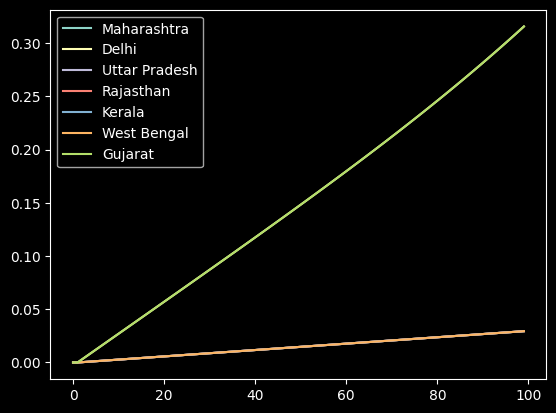

In [ ]:
vaccine_distribution_center_building_process = VaccineDistributionCenterBuildingProcess(
    "VaccineDistributionCenterBuildingProcess",
    {"india": ind},
    "ALIVE",
    country=["india", "india"],
    state=["Delhi", "Gujarat", ],
    num_centers=[1, 1],
    vaccine_type="ABC",
)

k = []
for i in range(100):
    k.append(vaccine_distribution_center_building_process.run(i))
    ind.sync()

data = {}
for i in k:
    for key, val in i.items():
        if key.split("_")[1] not in data:
            data[key.split("_")[1]] = []

        data[key.split("_")[1]].append(val)

for d in data:
    plt.plot(data[d], label=d)
plt.legend()
plt.show()

### **DS Parameter**

Changes value of Susceptable and move to Dead

In [ ]:
# Make a process to increase Ds value in each of loci of all countries in entities with similar class structure as above


class IncreaseDsProcess(ProcessV1):
    RANK = 1
    DOMAIN = (gpe.Country,)

    def __init__(self, id: str, entities, status: str):
        super().__init__(id, entities, status)

    def while_dormant(self, step: int):
        pass

    def scale_Ds_value(self, input_value, susceptible_percent):
        # Scale the input value from the input range to the output range
        scaled_value = (input_value * susceptible_percent - 0) / (
            max_living_population - min_living_population
        ) * (5e-3 - 5e-5) + 5e-5
        return scaled_value

    def while_alive(self, step: int):
        for country in self.entities:
            for locus in country.loci:
                print(locus.name)
                print(locus.Ds, "Start")
                if locus.susceptible > 0 and locus.Ds < 0.2 and locus.Ds > 0:
                    # Calculate the percentage of susceptible people in the locus
                    susceptible_percent = locus.susceptible / (
                        locus.susceptible + locus.infected + locus.recovered
                    )

                    # Calculate scale based on country attributes and susceptible percent
                    scale = self.scale_Ds_value(
                        base_death_rate
                        * (1 - (min_gdp / country.gdp))
                        * country.happiness_index
                        * country.human_welfare_resource,
                        susceptible_percent,
                    )
                    if locus.Ds + scale <= 0.2:
                        locus.Ds += scale
                    else:
                        locus.Ds = 0.2

                    if locus.susceptible > 0:
                        percent_to_move = locus.Ds * locus.susceptible
                        locus.infected += percent_to_move
                        locus.susceptible -= percent_to_move
                    else:
                        locus.susceptible = 0

                print(locus.Ds, "End")

        return {
            "IncreaseBProcess"
            + "_"
            + str(locus.name)
            + "_"
            + str(country): [
                locus.susceptible,
                locus.infected,
                locus.recovered,
                locus.dead,
            ]
            for locus in self.entities[country].loci
        }

    def run(self):
        if self.status == "ALIVE":
            return self.while_active()